In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn import metrics
from sklearn.cluster import DBSCAN
from random import sample
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [18]:
IDs = [25]
data_dict = {}

for ID in IDs:
    filepath = f'/Users/benjaminhanf/Desktop/pomona_s25/thesis/gp_download_action_finding/{ID}/savez_arrays_{ID}.npz'
    data = np.load(filepath)
    # print(f"Keys in {filepath}:", list(data.keys()))
    
    jr = data['jr']
    jp = data['jp']
    jz = data['jz']
    
    data_dict[ID] = data
# print(len(data_dict[25]['jp']))

In [19]:
for ID in IDs:
    imported_data = data_dict[ID]
    x, y, z = imported_data['x'], imported_data['y'], imported_data['z']
    actions = np.array([imported_data['jr'], imported_data['jp'], imported_data['jz']]).T

Trying min_cluster_size: 2505
Clusters found: 2, error: 23
Trying min_cluster_size: 1257
Clusters found: 2, error: 23
Trying min_cluster_size: 633
Clusters found: 2, error: 23
Trying min_cluster_size: 321
Clusters found: 2, error: 23
Trying min_cluster_size: 165
Clusters found: 2, error: 23
Trying min_cluster_size: 87
Clusters found: 2, error: 23
Trying min_cluster_size: 48
Clusters found: 2, error: 23
Trying min_cluster_size: 28
Clusters found: 2, error: 23
Trying min_cluster_size: 18
Clusters found: 2, error: 23
Trying min_cluster_size: 13
Clusters found: 2, error: 23
Trying min_cluster_size: 11
Clusters found: 2, error: 23
Trying min_cluster_size: 10
Clusters found: 2, error: 23


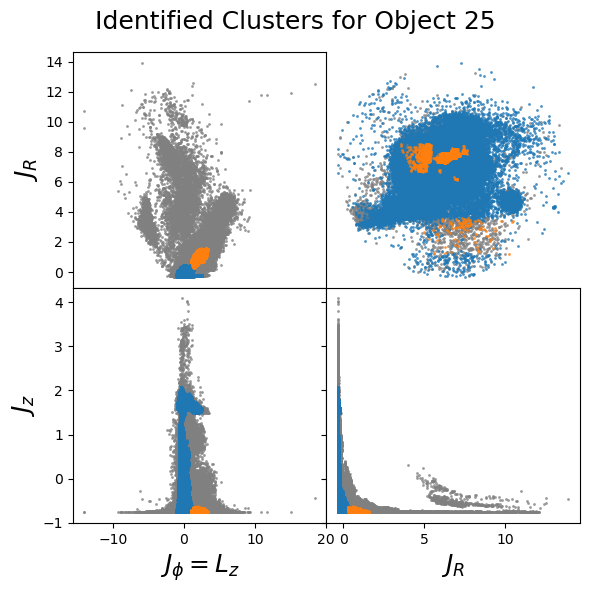

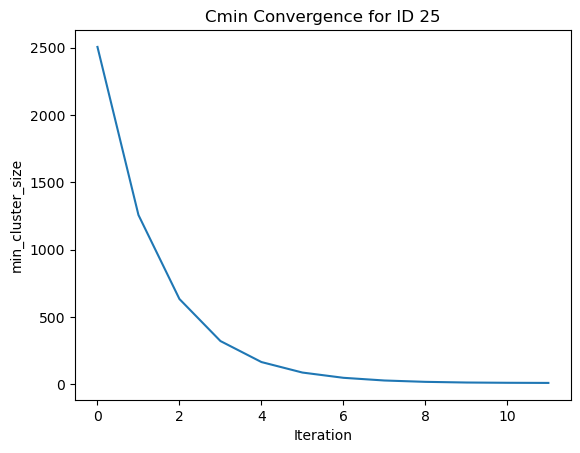

In [ ]:
# IDs = [11, 12, 13, 24, 25, 28]
IDs = [25]
target_cluster_num = 25
n = 1  # downsampling
size = 4
alph = 0.8
font_size = 18
random_state = 47
tolerance = 2
lw = 0
labels_dict = {}

for ID in IDs:
    imported_data = data_dict[ID]
    x, y, z = imported_data['x'], imported_data['y'], imported_data['z']
    actions = np.array([imported_data['jr'], imported_data['jp'], imported_data['jz']]).T

    data = actions
    scaler = StandardScaler()
    transformed_data = scaler.fit_transform(data)[::n]
    x_down = x[::n]
    y_down = y[::n]

    # binary search over values of min_cluster_size
    lo, hi = 10, 5000
    best_error = float('inf')
    best_labels = None
    best_cmin = None
    cmin_list = []

    while lo <= hi:
        cmin = (lo + hi) // 2
        print(f"min_cluster_size: {cmin}")

        hdb = HDBSCAN(min_cluster_size=cmin, min_samples=5,
                      cluster_selection_epsilon=0.5, n_jobs=-2).fit(transformed_data)

        labels = hdb.labels_
        unique_labels = set(labels)
        num_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        error = abs(target_cluster_num - num_clusters)

        print(f"clusters found: {num_clusters}, error: {error}")
        cmin_list.append(cmin)

        if error < best_error:
            best_error = error
            best_labels = labels
            best_cmin = cmin

        if error <= tolerance:
            break

        if num_clusters > target_cluster_num:
            lo = cmin + 1
        else:
            hi = cmin - 1

    # plot
    if best_labels is not None:
        labels = best_labels
        X_T = transformed_data.T
        unique_labels = set(labels)
        labels_dict[ID] = labels
        
        fig = plt.figure(figsize=(6, 6))
        gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
        axs = gs.subplots(sharex=False, sharey=False)

        label_counts = Counter(labels)
        sorted_labels = [lbl for lbl, _ in sorted(label_counts.items(), key=lambda x: -x[1]) if lbl != -1]
        default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        X_T = transformed_data.T

        for i, label in enumerate(sorted_labels):
            cluster_indices = (labels == label)
            color = default_colors[i % len(default_colors)]

            axs[0, 0].scatter(X_T[1][cluster_indices], X_T[0][cluster_indices], s=size, alpha=alph, color=color, zorder=1+i, linewidths=lw)
            axs[1, 0].scatter(X_T[1][cluster_indices], X_T[2][cluster_indices], s=size, alpha=alph, color=color, zorder=1+i, linewidths=lw)
            axs[1, 1].scatter(X_T[0][cluster_indices], X_T[2][cluster_indices], s=size, alpha=alph, color=color, zorder=1+i, linewidths=lw)
            axs[0, 1].scatter(x[::n][cluster_indices], y[::n][cluster_indices], s=size, alpha=alph, color=color, zorder=1+i, linewidths=lw)

        # Plot noise last in grey
        if -1 in label_counts:
            cluster_indices = (labels == -1)
            axs[0, 0].scatter(X_T[1][cluster_indices], X_T[0][cluster_indices], s=size, alpha=alph, color="grey", zorder=-1, linewidths=lw)
            axs[1, 0].scatter(X_T[1][cluster_indices], X_T[2][cluster_indices], s=size, alpha=alph, color="grey", zorder=-1, linewidths=lw)
            axs[1, 1].scatter(X_T[0][cluster_indices], X_T[2][cluster_indices], s=size, alpha=alph, color="grey", zorder=-1, linewidths=lw)
            axs[0, 1].scatter(x[::n][cluster_indices], y[::n][cluster_indices], s=size, alpha=alph, color="grey", zorder=-1, linewidths=lw)

        axs[0, 0].set_xlabel(r'$J_{\phi} = L_z$', fontsize=font_size)
        axs[0, 0].set_ylabel(r'$J_R$', fontsize=font_size)
        axs[1, 0].set_xlabel(r'$J_{\phi} = L_z$', fontsize=font_size)
        axs[1, 0].set_ylabel(r'$J_z$', fontsize=font_size)

        axs[1, 1].set_xlabel(r'$J_R$', fontsize=font_size)
        axs[1, 1].set_ylabel('')
        axs[1, 1].tick_params(labelleft=False, labelbottom=True)
        axs[0, 1].axis('off')

        fig.suptitle(f'Identified Clusters for Object {ID}', fontsize=font_size)
        plt.tight_layout()
        fig.savefig(f'cluster_plot_{ID}_run6.jpg', dpi=300, bbox_inches='tight')
        # fig.savefig(f'cluster_plot_{ID}.pdf', bbox_inches='tight')
        plt.show()
            
        plt.plot(range(len(cmin_list)), cmin_list)
        plt.xlabel('Iteration')
        plt.ylabel('min_cluster_size')
        plt.title(f'Cmin Convergence for ID {ID}')
        plt.savefig(f'cmin_convergence_{ID}_run6.pdf')
        plt.show()

np.save('./labels_dict6',labels_dict, allow_pickle=True)

In [20]:
#evaluate performance

# ground truth
with open('/Users/benjaminhanf/Desktop/pomona_s25/thesis/green_planet/historic_streams/extracted_labels_25.pkl', 'rb') as f:
    extracted_labels_25 = pickle.load(f)

# clustered
with open('/Users/benjaminhanf/Desktop/pomona_s25/thesis/green_planet/historic_streams/labels_dict_thesis_eve.npy', 'rb') as f:
    cluster_labels_25 = np.load(f, allow_pickle=True)

with open('/Users/benjaminhanf/Desktop/pomona_s25/thesis/green_planet/historic_streams/labels_dict_thesis_eve3.npy', 'rb') as f:
    cluster_labels_25_3 = np.load(f, allow_pickle=True)

with open('/Users/benjaminhanf/Desktop/pomona_s25/thesis/green_planet/historic_streams/labels_dict_thesis_eve4.npy', 'rb') as f:
    cluster_labels_25_4 = np.load(f, allow_pickle=True)

clustering_data1 = cluster_labels_25[()][25]
clustering_data3 = cluster_labels_25_3[()][25]
clustering_data4 = cluster_labels_25_4[()][25]

extract_data = extracted_labels_25
len(clustering_data1) - len(extract_data) #=0

0

In [26]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import rand_score
adjusted_rand_score([0, 0, 1, 1], [1, 1, 0, 4])
# rand_score([0, 0, 1, 1], [4, 4, 2, 9])

0.5714285714285714

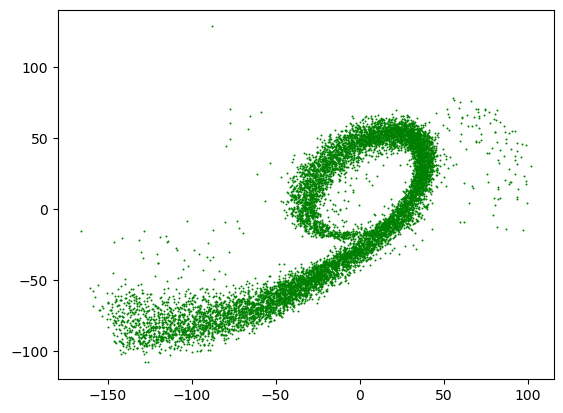

In [29]:
testid = 1203
plt.scatter(x[extract_data == testid], y[extract_data == testid],c='green', s=2, linewidths=0)
# plt.scatter(x[labels == 0], y[labels == 0] + 250,c='royalblue', s=1, linewidths=0)

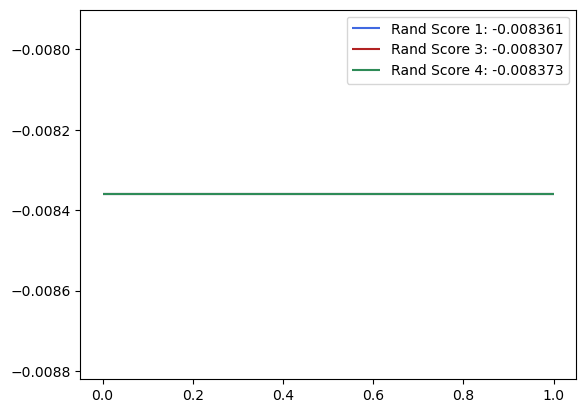

In [ ]:
randscore1 = adjusted_rand_score(extract_data, clustering_data1)
randscore3 = adjusted_rand_score(extract_data, clustering_data3)
randscore4 = adjusted_rand_score(extract_data, clustering_data4)

# print("Adjusted Rand Score 1: " + str(randscore1))
plt.hlines(randscore1, 0, 1, label = "Rand Score 1: " + str(round(randscore1, 6)), color='royalblue')
plt.hlines(randscore1, 0, 1, label = "Rand Score 3: " + str(round(randscore3, 6)), color='firebrick')
plt.hlines(randscore1, 0, 1, label = "Rand Score 4: " + str(round(randscore4, 6)), color='seagreen')

# plt.hlines(0,0,1, color="grey", linestyles='dashed', label='Random Labels')
# plt.ylim(-0.5, 1)
plt.legend()
plt.savefig('./rand_score_performance.jpg', dpi=200)